In [ ]:

    
def generate_binary_map(delta_x, delta_y, delta_w, delta_h):
    """
    Create binary matrices for human and object bounding boxes

    Args:
        delta_x (float): Relative x-position (∆xoh = (xo-xh)/wh)
        delta_y (float): Relative y-position (∆yoh = (yo-yh)/hh)
        delta_w (float): Relative width (∆woh = log(wo/wh))
        delta_h (float): Relative height (∆hoh = log(ho/hh))
        grid_size (int): Size of the grid
        human_width (float, optional): Width of human box
        human_height (float, optional): Height of human box

    Returns:
        tuple: (human_matrix, object_matrix)
    """
    # # Default human box size if not provided
    # if human_width is None:
    #     human_width = 100 * 0.3
    # if human_height is None:
    #     human_height = 100 * 0.3

    human_width = human_height = 100
    # # Create blank matrices
    # human_matrix = np.zeros((grid_size, grid_size), dtype=np.uint8)
    # object_matrix = np.zeros((grid_size, grid_size), dtype=np.uint8)

    # Human box parameters
    human_x = int(0)
    human_y = int(0)

    # Calculate object box parameters based on deltas
    obj_x = int(human_x + delta_x * human_width)
    obj_y = int(human_y + delta_y * human_height)

    # Calculate object box width and height
    obj_width = int(human_width * np.exp(delta_w))
    obj_height = int(human_height * np.exp(delta_h))
    
    global_x1 = min(human_x,obj_x)
    global_y1 = min(human_y,obj_y)
    
    global_x2 = max(human_x + human_width,obj_x + obj_width)
    global_y2 = max(human_y + human_height,obj_x + obj_height)
    
    #initializing the binary map
    # human_matrix = np.ones((human_height,human_width))
    # object_matrix = np.ones((obj_height, obj_width))
    
    binary_map1 = np.zeros((global_y2-global_y1, global_x2-global_x1))
    binary_map2 = np.zeros((global_y2-global_y1, global_x2-global_x1))
    binary_map1[human_y:human_height,human_x:human_width] = 1
    binary_map2[obj_y:obj_height, obj_x:obj_width] = 1
    
    
    object_binary_map = torch.Tensor(binary_map2).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    # Scale binary maps to 1000x1000 using interpolation
    # scaled_human_map = torch.nn.functional.interpolate(o, size=(1000, 1000), mode='bilinear', align_corners=False)
    scaled_object_map = nn.functional.interpolate(object_binary_map, size=(1000, 1000), mode='bilinear', align_corners=False)
    # # Fill human matrix
    # x_start = int(human_x)
    # y_start = int(grid_size - human_y - human_height)
    # x_end = int(human_x + human_width)
    # y_end = int(grid_size - human_y)
    # human_matrix[y_start:y_end, x_start:x_end] = 1

    # # Fill object matrix
    # x_start = int(obj_x)
    # y_start = int(grid_size - obj_y - obj_height)
    # x_end = int(obj_x + obj_width)
    # y_end = int(grid_size - obj_y)
    # object_matrix[y_start:y_end, x_start:x_end] = 1

    return binary_map1, scaled_object_map

mapp1, mapp2 = generate_binary_map(0.5, 0.5, 0.0, 0.0)

import matplotlib.pyplot as plt

plt.imshow(mapp1, cmap='gray')
plt.figure()
plt.imshow(mapp2.reshape(1000,1000), cmap='gray')


In [ ]:
import torch
ims, y = get_batch(20)
#c = 2048
feature_map = backbone(ims) #output from backbone
position_encoded_feature_map = positionEncoder(feature_map)
B,C,W,H = position_encoded_feature_map.shape # (Batch, Channels, Width, Height)
backbone_output_vectorized = position_encoded_feature_map.reshape((B,C,W*H)) #changing 2d image to vector (B, C, F) (F = feature)
backbone_output_tansformed = backbone_output_vectorized.permute([0,2,1]) # (B, F, C)
# backbone_output_tansformed = position_encoded_feature_map.permute([0,3,2,1]) # (B, H,W, C)
encoder_output = encoder(backbone_output_tansformed) # (B, F, C)

OASampler = OACandidateSampler(num_oas)
probabilities = OASampler(encoder_output)

print(probabilities.shape)
# confidences, indices = torch.topk(probabilities, 5, dim=-1)
# print("Top-K OA Candidates (indices):", indices)
# print("Top-K OA Candidates (confidences):", confidences)

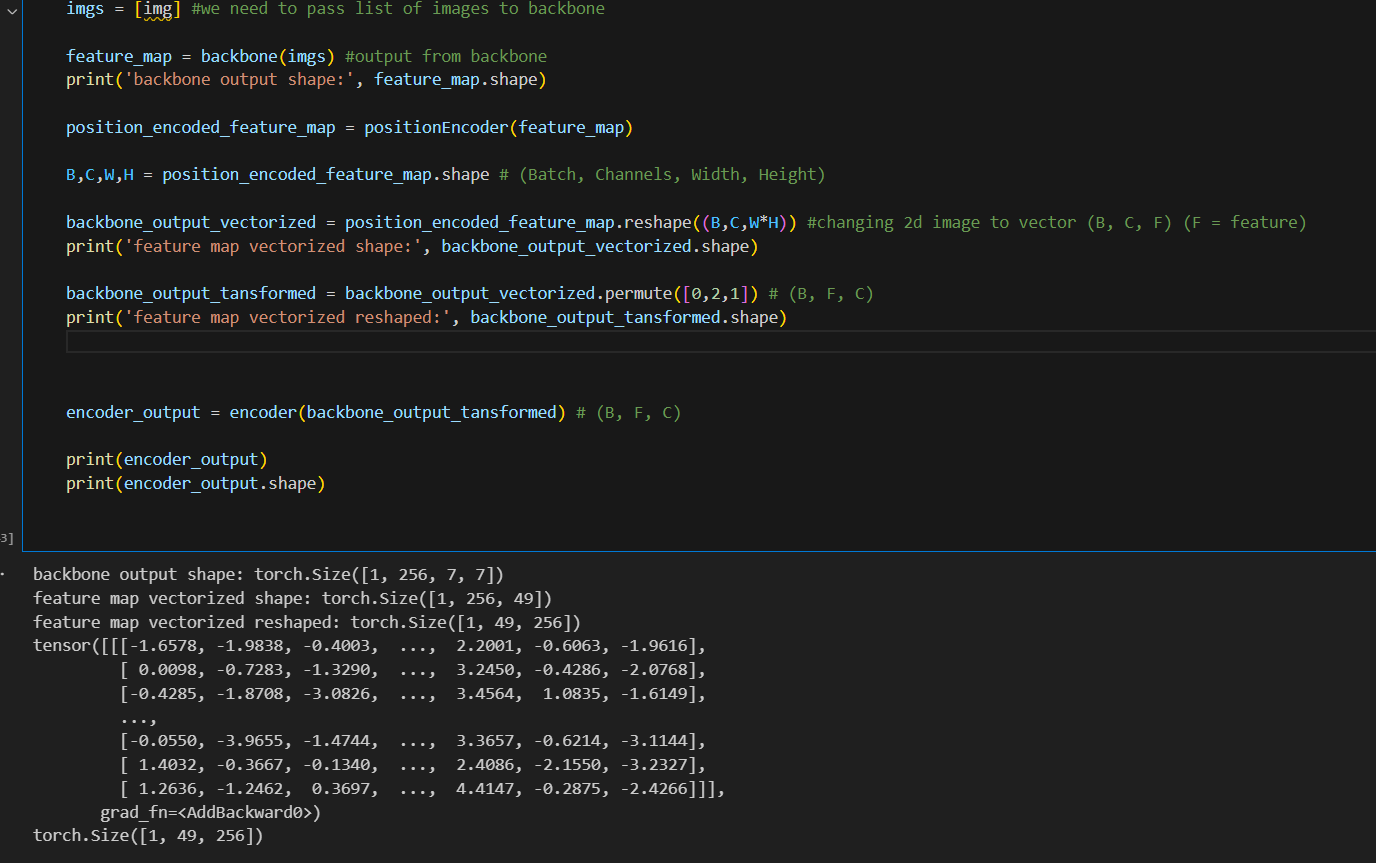

In [ ]:
import SpatialFeatureGenerator

reload(SpatialFeatureGenerator)
spatial_feature_generator = SpatialFeatureGenerator.SpatialFeatureGenerator([])

oa_ids = torch.tensor([[1]], dtype=torch.int32)
maps = spatial_feature_generator.generate_binary_map(oa_ids)

print(maps.shape)
plt.subplot(1,2,1)
plt.imshow(maps[0,0,0], cmap='gray_r')
plt.subplot(1,2,2)

plt.imshow(maps[0,0,1], cmap='gray_r')

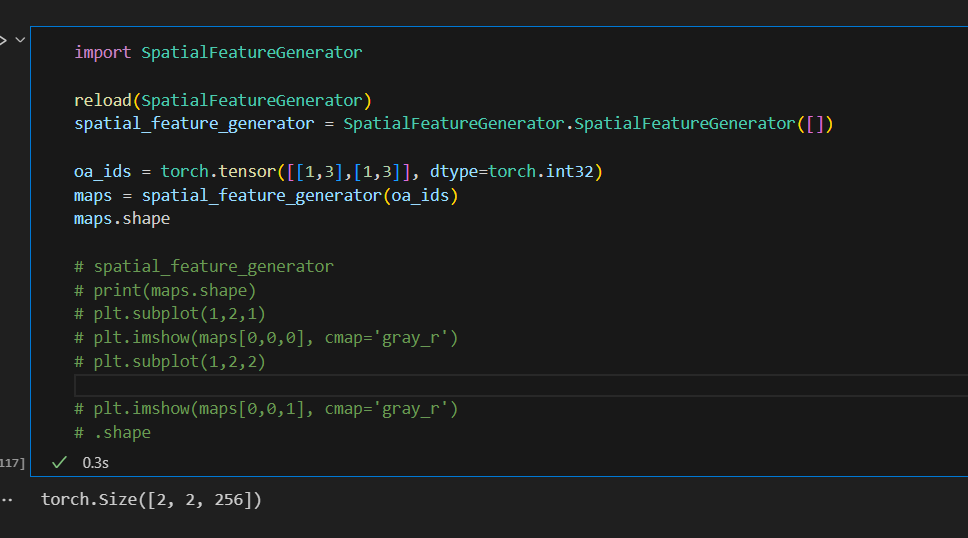